In [2]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from pymc3.gp.util import plot_gp_dist
%matplotlib inline

## Gaussian process

$$
y = \alpha +\beta\,x
$$
Is my model really linear?

$$
y = \alpha +\beta\,x+\gamma\,x^2
$$
Is my model really quadratic?

$$
y = w_0 +w_1 \,\tanh(\alpha_1 +\beta_1\,x)+w_2 \,\tanh(\alpha_2 +\beta_2\,x)
$$
Do I need more hidden-units?

$$
y = w_0 +w_1 \,\cos(x)+w_2 \cos(2 x)+w_3 \cos(3 x)
$$
Do I need more frequencies?



In [ ]:
with pm.Model() as model:
    #priors
    alpha = pm.Normal('alpha', mu=0, sd=30)
    beta = pm.Normal('beta', mu=0, sd=30)
    #Transformed parameter
    mu = pm.Deterministic('mu', alpha + beta * x1)#Linear Regression 
    #Likelihood
    gamma = pm.HalfCauchy('gamma', 5)
    y_o = pm.Normal('y_obs', mu=mu, sd=gamma, observed=y1)

The above models are different ways to solve this problem: given observations $\{(x_i,y_i): i=1,2,\dots,n\}$
we want to  estimate the function $f$ in:
$$
y = f(x)
$$

Can we place directly a prior over functions?

In [ ]:
with pm.Model() as model:
    #priors
    f = pm.PriorOverFunction(description) # this command does not exist in pymc3
    #Likelihood
    gamma = pm.HalfCauchy('gamma', 5)
    y_o = pm.Normal('y_obs', mu=f, sd=gamma, observed=y1)

What is this description ?

Some high-level description:
* function is linear
* function is non-linear
* function is smooth
* function is not too wiggly
* function is very wiggly
* function is periodic
* function is the sum of a linear function and a periodic function

Maybe we can also have some universal approximation property and so be able to model any function.

Text(0.5, 0, 'y')

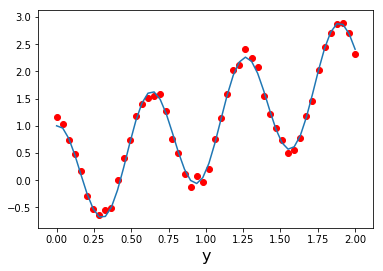

In [ ]:
# A one dimensional column vector of inputs.
X = np.linspace(0, 2, 50)[:,None] # LINEAR
yt = X + np.cos(10*X)             # PERIODIC
y = yt + np.random.randn(len(X),1)/10

plt.plot(X,yt)
plt.scatter(X,y,c='r')
plt.xlabel("x",fontsize=16)
plt.xlabel("y",fontsize=16)

In [ ]:
import numpy as np
import pymc3 as pm

with pm.Model() as latent_gp_model:
    # Specify the covariance function. This is the description
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP. 
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    like = pm.Normal("y", mu=f,  sigma=σ, observed=y[:,0])
    
    posterior = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, f_rotated_]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:38<00:00, 261.80draws/s]


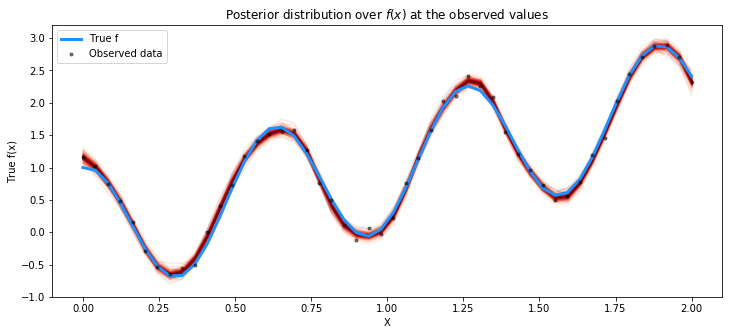

In [ ]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading

plot_gp_dist(ax, posterior["f"], X);

# plot the data and the true latent function
plt.plot(X, yt, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [ ]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 3, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with latent_gp_model:
    f_pred = gp.conditional("f_pred", X_new)



In [ ]:
# Sample from the GP conditional distribution
with latent_gp_model:
    pred_samples = pm.sample_posterior_predictive(posterior, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:19<00:00, 50.71it/s]


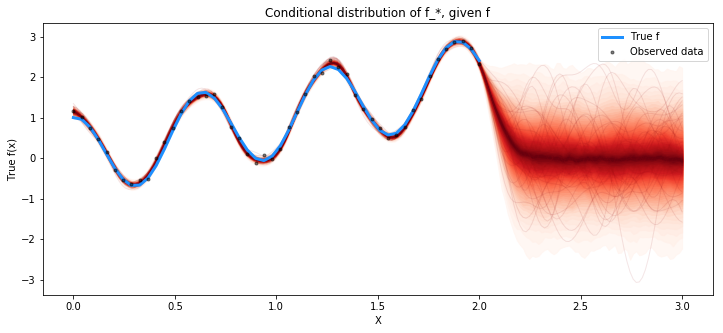

In [ ]:


# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, yt, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();



## Gaussian process
For fixed values of the inputs $[x_1,x_2,\dots,x_m]$, GP assumes that the values of the function at those points 
$[f(x_1),f(x_2),\dots,f(x_m)]$ are multivariate Gaussian distributed with zero mean and covariance function
determined by the Kernel function. You saw kernels is SVM.

Here a video about the multivariate Gaussian distribution
https://www.youtube.com/watch?v=eho8xH3E6mE

In other words, we can sample functions from a multivariate Gaussian distribution

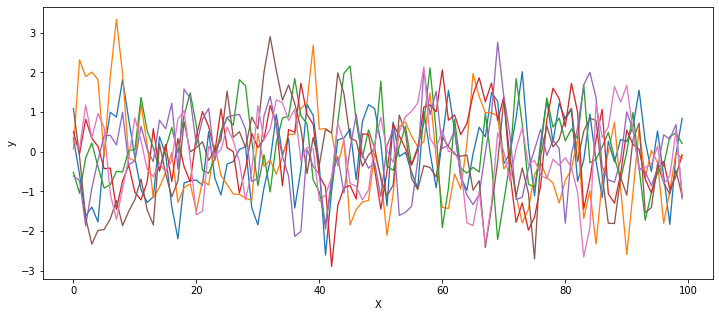

In [ ]:
n = 100 # The number of data points
X = np.linspace(0, 99, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Description 
ℓ_true = 1
η_true = 1.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

#cov_func = η_true**2 * pm.gp.cov.ExpQuad(1,    ℓ_true)

#cov_func = η_true**2 * pm.gp.cov.Periodic(1,  2, ℓ_true)

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
for i in range(7):
    # The latent function values are one sample from a multivariate normal
    # Note that we have to call `eval()` because PyMC3 built on top of Theano
    f_true = np.random.multivariate_normal(np.zeros(len(X)),
                                           cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

   
    ax.plot(X, f_true, lw=1.3, label="True f");
    ax.set_xlabel("X"); ax.set_ylabel("y"); #plt.legend();

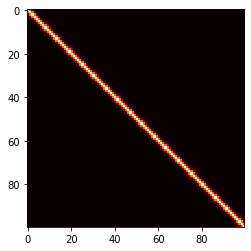

In [ ]:
plt.imshow(cov_func(X).eval(), cmap='hot', interpolation='nearest')

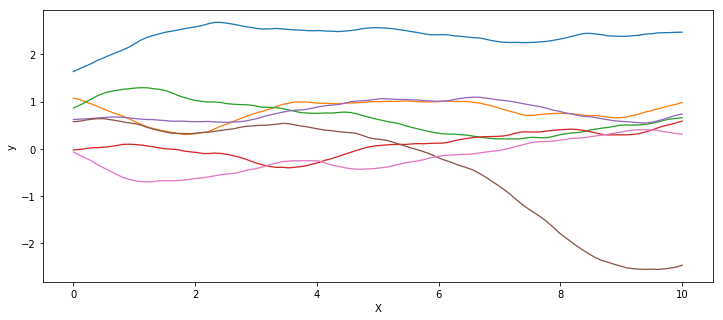

In [ ]:
n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Description 
ℓ_true = 5.0
η_true = 1.0
cov_func = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true)



fig = plt.figure(figsize=(12,5)); ax = fig.gca()
for i in range(7):
    # The latent function values are one sample from a multivariate normal
    # Note that we have to call `eval()` because PyMC3 built on top of Theano
    f_true = np.random.multivariate_normal(np.zeros(len(X)),
                                           cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

   
    ax.plot(X, f_true, lw=1.3, label="True f");
    ax.set_xlabel("X"); ax.set_ylabel("y"); #plt.legend();

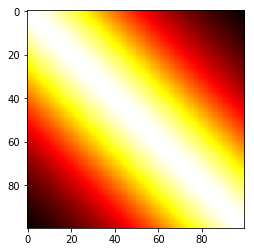

In [ ]:
plt.imshow(cov_func(X).eval(), cmap='hot', interpolation='nearest')

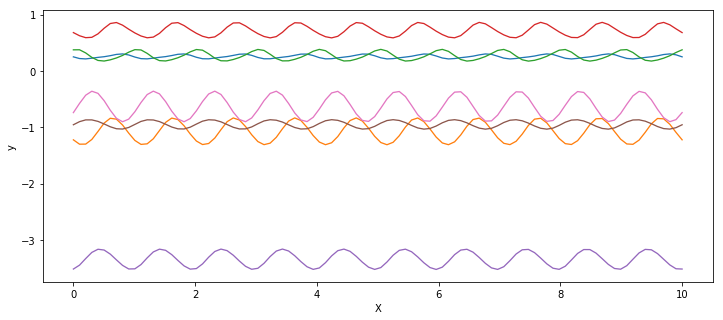

In [ ]:
n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Description 
ℓ_true = 4.0
η_true = 1.0


cov_func = η_true**2 * pm.gp.cov.Periodic(1,  1, ℓ_true)

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
for i in range(7):
    # The latent function values are one sample from a multivariate normal
    # Note that we have to call `eval()` because PyMC3 built on top of Theano
    f_true = np.random.multivariate_normal(np.zeros(len(X)),
                                           cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

   
    ax.plot(X, f_true, lw=1.3, label="True f");
    ax.set_xlabel("X"); ax.set_ylabel("y"); #plt.legend();

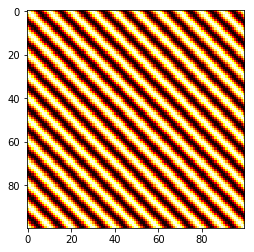

In [ ]:
plt.imshow(cov_func(X).eval(), cmap='hot', interpolation='nearest')

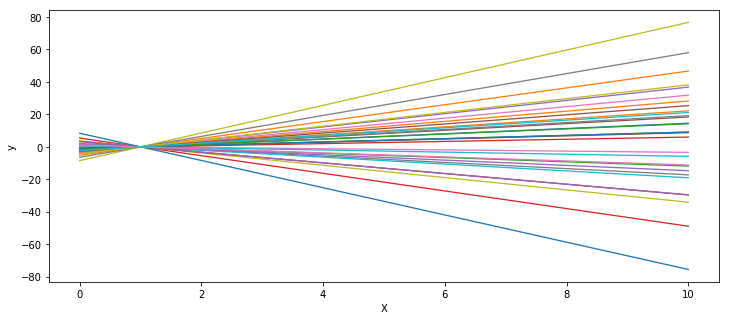

In [ ]:
n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Description 
c = 1.0 #intercept
tau = 10 #scaling

cov_func =  tau*pm.gp.cov.Linear(1,  c) #Linear

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
for i in range(30):
    # The latent function values are one sample from a multivariate normal
    # Note that we have to call `eval()` because PyMC3 built on top of Theano
    f_true = np.random.multivariate_normal(np.zeros(len(X)),
                                           cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

   
    ax.plot(X, f_true, lw=1.3, label="True f");
    ax.set_xlabel("X"); ax.set_ylabel("y"); #plt.legend();

## A function that is the sum of a linear and periodic function

Text(0.5, 0, 'y')

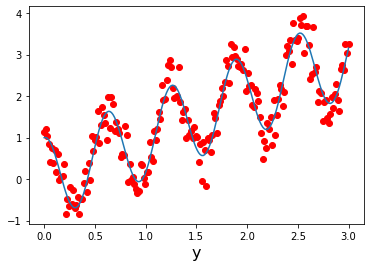

In [ ]:
# A one dimensional column vector of inputs.
X = np.linspace(0, 3, 200)[:,None]
yt = X + np.cos(10*X)
y = yt + np.random.randn(len(X),1)/3

plt.plot(X,yt)
plt.scatter(X,y,c='r')
plt.xlabel("x",fontsize=16)
plt.xlabel("y",fontsize=16)

In [ ]:
y_pd = pd.DataFrame(y)
y_pd.shape

(200, 1)

In [ ]:
y[:,0]

array([ 1.1285813 ,  1.2155223 ,  1.03795367,  0.84528824,  0.4157339 ,
        0.74077246,  0.38635167,  0.70925615,  0.16842678,  0.603184  ,
       -0.02400521,  0.0394818 ,  0.06816195,  0.37109477, -0.8380034 ,
       -0.47134203, -0.64365643, -0.1788751 , -0.58880208, -0.25907219,
       -0.70261482, -0.62995355, -0.44025756, -0.83626657, -0.47217066,
       -0.48686832, -0.10527377,  0.18914193, -0.3145356 ,  0.39906936,
       -0.02750665,  1.02747154,  0.66907891,  0.94824542,  1.00981437,
        1.634553  ,  0.86973005,  1.30432875,  1.74642401,  1.55504225,
        1.343208  ,  0.93503129,  1.97801777,  1.24111744,  1.97576978,
        1.80632666,  1.16067138,  1.38560909,  1.2045641 ,  1.11045016,
        0.53443455,  0.61383569,  0.57445903,  1.28230021,  1.06829474,
       -0.05886609,  0.36511384, -0.01575997,  0.05089559, -0.12716256,
       -0.23534034, -0.34486539, -0.28197526,  0.37472892,  0.3320553 ,
        0.0215378 , -0.12494718,  0.17287267,  0.1771696 ,  0.88

In [ ]:
with pm.Model() as model:
    #  periodic component x 
    ## PRIORS - periodic ##
    η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
    period  = pm.Normal("period", mu=1, sigma=3)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=1, beta=1)
    ## PRIORS ##

    #'periodic function' to attempt to account for oscillating data
    cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth)     
    gp1 = pm.gp.Marginal(cov_func=cov_seasonal)
    
    #  linear component x
    ## PRIORS - linear ##
    tau = pm.HalfCauchy("tau", beta=2, testval=1.0)
    c  = pm.Normal("c", mu=0, sigma=1)
    ## PRIORS - linear ##

    #'linear function' to attempt to account for 'increasing' sales data
    cov_linear = tau * pm.gp.cov.Linear(1, c)     
    gp2 = pm.gp.Marginal(cov_func=cov_linear)

    # gp represents f1 + f2.
    gp = gp1 + gp2

    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)

    # LIKELYHOOD #
    f = gp.marginal_likelihood("f", X, y[:,0], noise=sigma)
    # LIKELYHOOD #
    
    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -87.022, ||grad|| = 1.702: 100%|██████████| 53/53 [00:01<00:00, 40.26it/s]  


In [ ]:
#optimized parameters
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['c:0.006446769333426789',
 'period:0.6259489804121018',
 'sigma:0.33132186569652644',
 'tau:0.6981141987802103',
 'η_per:0.9595365400617408',
 'ℓ_psmooth :0.9611025023694474']

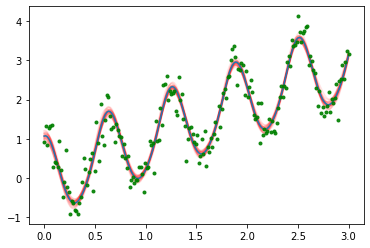

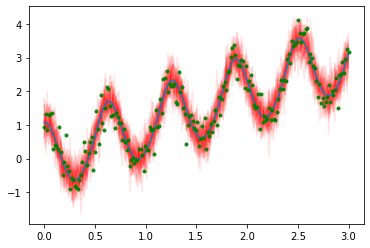

In [ ]:
# 200 new values from x=0 to x=3
n_new = 200
X_new = np.linspace(0, 3, n_new)[:,None]

#periodic term
f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": y[:,0], "noise": sigma})
y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": y[:,0], "noise": sigma}, pred_noise=True)
#linear term
f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": y[:,0], "noise": sigma})
y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": y[:,0], "noise": sigma}, pred_noise=True)

#SUM of periodic AND linear term
y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": y[:,0], "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": y[:,0], "noise": sigma})

#we sample 10 regression lines from the posterior
sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_f.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

plt.figure()
#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_y.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

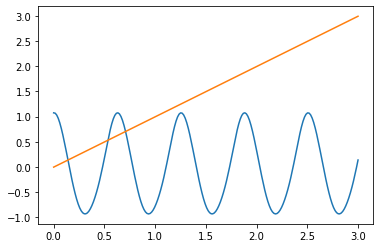

In [ ]:
#we can recover the single components
## function DECOMPOSITION
plt.plot(X_new[:,0],f1_pred[0])
plt.plot(X_new[:,0],f2_pred[0])

#plt.plot(X, y, 'or', ms=3, alpha=0.9, label="Observed data");

## A function that is the product of a linear and periodic function


Text(0.5, 0, 'y')

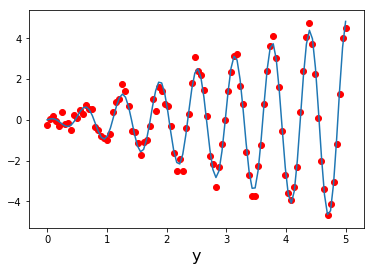

In [ ]:
# A one dimensional column vector of inputs.
X = np.linspace(0, 5, 100)[:,None]
yt = X*np.cos(10*X)
y = yt + np.random.randn(len(X),1)/3

plt.plot(X,yt)
plt.scatter(X,y,c='r')
plt.xlabel("x",fontsize=16)
plt.xlabel("y",fontsize=16)

In [ ]:
with pm.Model() as model:

    #  periodic component x 
    η_per = pm.HalfCauchy("η_per", beta=2, testval=0.1)
    period  = pm.Normal("period", mu=1, sigma=3)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=1, beta=1)
    cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth)     
    #gp1 = pm.gp.Marginal(cov_func=cov_seasonal)
    
    #  linear component x 
    tau = pm.HalfCauchy("tau", beta=2, testval=1.0)
    #c0  = pm.HalfCauchy("c0", beta=2, testval=1.0)   
    c  = pm.Normal("c", mu=0, sigma=1) 
    cov_linear = tau * pm.gp.cov.Linear(1, c)     
    
    #product for two different covariance
    gp = pm.gp.Marginal(cov_func=cov_seasonal*cov_linear)
    
    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
    f = gp.marginal_likelihood("f", X, y[:,0], noise=sigma)
    
    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

logp = -56.041, ||grad|| = 0.0041508: 100%|██████████| 73/73 [00:00<00:00, 351.67it/s]  


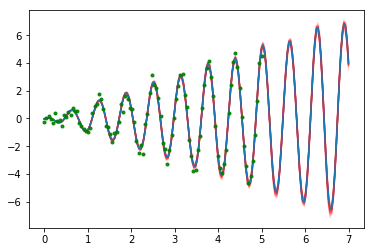

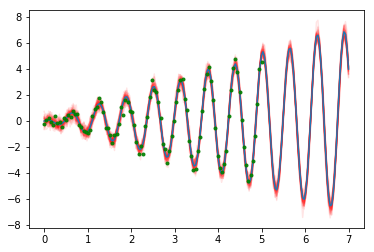

In [ ]:
# 200 new values from x=0 to x=3
n_new = 200
X_new = np.linspace(0, 7, n_new)[:,None]

#sum of periodic and linear term
y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": y[:,0], "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": y[:,0], "noise": sigma})

#we sample 10 regression lines from the posterior
sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_f.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

plt.figure()
#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_y.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

# A more complicated function

Text(0.5, 0, 'y')

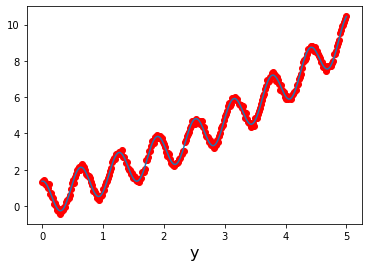

In [3]:
# A one dimensional column vector of inputs.
X = np.linspace(0, 5, 300)[:,None]
yt = X+ np.cos(10*X) + np.exp(0.1+X/2)/3 #*np.exp(X**0.5) + np.exp(0.1+X/2)/3
y = yt + np.random.randn(len(X),1)/10

plt.plot(X,yt)
plt.scatter(X,y,c='r')
plt.xlabel("x",fontsize=16)
plt.xlabel("y",fontsize=16)

In [4]:
## STANDARDIZE THE MODEL DATA
y_n = (y -np.mean(y))/np.std(y)
X_n = (X-np.mean(X))/np.std(X)

In [ ]:

with pm.Model() as model:
    #  generic component x 
    η_s = pm.HalfCauchy("η_s", beta=5, testval=1)
    ℓ_smooth = pm.Gamma("ℓ_smooth ", alpha=1, beta=1 )
    cov_generic = η_s**2 * pm.gp.cov.ExpQuad(1,  ℓ_smooth)     
    gp1 = pm.gp.Marginal(cov_func=cov_generic)
    
    #  periodic component x 
    η_per = pm.HalfCauchy("η_per", beta=5, testval=1)
    #period  = pm.Normal("period", mu=1, sigma=2)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=1, beta=1)
    cov_seasonal = η_per**2 * pm.gp.cov.Cosine(1,  ℓ_psmooth)     
    gp2 = pm.gp.Marginal(cov_func=cov_seasonal)
    
    #  linear component x 
    tau = pm.HalfCauchy("tau", beta=2,  testval=1)
    #c0  = pm.HalfCauchy("c0", beta=2, testval=1.0)   
    c  = pm.Normal("c", mu=0, sigma=1) 
    cov_linear = tau * pm.gp.cov.Linear(1, c)     
    gp3 = pm.gp.Marginal(cov_func=cov_linear)
    
    # gp represents f1 + f2 + f3.
    gp =  gp1 + gp2 + gp3
    
    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.5)
    f = gp.marginal_likelihood("f", X_n, y_n[:,0], noise=sigma)
    
    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)


/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = -50.786, ||grad|| = 0.0075492: 100%|██████████| 72/72 [00:04<00:00, 16.12it/s]  


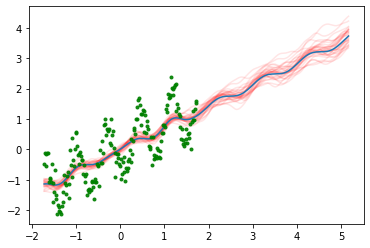

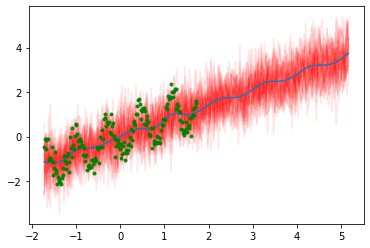

In [ ]:
# 200 new values from x=0 to x=3
n_new = 200
X_new = (np.linspace(0, 6, n_new)[:,None]-np.mean(X))/np.std(X)

#generic term
f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[:,0], "noise": sigma})
y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[:,0], "noise": sigma}, pred_noise=True)
#periodic term
f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[:,0], "noise": sigma})
y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[:,0], "noise": sigma}, pred_noise=True)
#linear term
f3_pred = gp3.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[:,0], "noise": sigma})
y3_pred = gp3.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[:,0], "noise": sigma}, pred_noise=True)

#SUM of periodic and linear term
y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[:,0], "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[:,0], "noise": sigma})


#we sample 10 regression lines from the posterior
sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_f.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X_n, y_n, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

plt.figure()
#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_y.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X_n, y_n, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

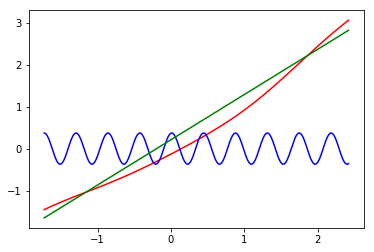

In [ ]:
plt.plot(X_new[:,0],f1_pred[0],c='r')
plt.plot(X_new[:,0],f2_pred[0],c='b')
plt.plot(X_new[:,0],f3_pred[0],c='g')

## A multidimensional example

In [ ]:
#This is the dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
import pandas as pd

#input variables
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

/home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
#output variable
boston['MEDV'] = boston_dataset.target #price of the house, last column
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
Val=  boston.values
#Here we prepare our data and normalize it so all the inputs and output range in [-4,4] approximatively.
X1 = Val[:,0:-1] #
Y1 = Val[:,-1:]

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size = 0.2, random_state=42)

#we normalize inputs and outputs
x1_scaler= StandardScaler().fit(X_train1)
X_train1_n= x1_scaler.transform(X_train1)
X_test1_n= x1_scaler.transform(X_test1)
y1_scaler= StandardScaler().fit(Y_train1)
Y_train1_n= y1_scaler.transform(Y_train1)
Y_test1_n= y1_scaler.transform(Y_test1)
print(X_train1.shape)
print(X_test1.shape)
print(Y_train1.shape)
print(Y_test1.shape)

(404, 13)
(102, 13)
(404, 1)
(102, 1)


In [ ]:

with pm.Model() as model:
    #  generic component x 
    η_s = pm.HalfCauchy("η_s", beta=5, testval=1)

    #Automatic Relevance Estimate
    ℓ_smooth = pm.Gamma("ℓ_smooth ", alpha=1, beta=1, shape=(X_train1.shape[1],))

    cov_generic = η_s**2 * pm.gp.cov.ExpQuad(X_train1.shape[1],  ℓ_smooth)     
    gp = pm.gp.Marginal(cov_func=cov_generic)
        
    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
    f = gp.marginal_likelihood("f", X_train1_n, Y_train1_n[:,0], noise=sigma)
    
    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

/home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tup

In [ ]:
mp

{'η_s_log__': array(0.06297537),
 'ℓ_smooth _log__': array([ 0.92297864,  1.64527745,  1.14949213, -9.544034  , -0.1001559 ,
         0.87375859,  1.14887663,  1.28753895,  0.77142371,  0.07226074,
         1.12406116,  1.53785373,  0.85985198]),
 'sigma_log__': array(-1.61687675),
 'η_s': array(1.0650006),
 'ℓ_smooth ': array([2.51677580e+00, 5.18244759e+00, 3.15658938e+00, 7.16273198e-05,
        9.04696368e-01, 2.39589916e+00, 3.15464708e+00, 3.62385708e+00,
        2.16284333e+00, 1.07493559e+00, 3.07732639e+00, 4.65458954e+00,
        2.36281092e+00]),
 'sigma': array(0.19851775)}

/home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


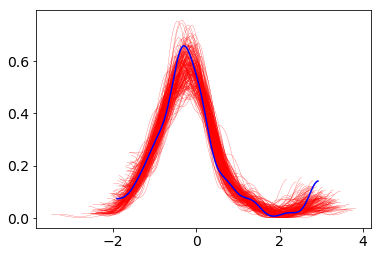

In [ ]:
#sum of periodic and linear term
y_pred  = gp.predict(X_test1_n, point=mp, given={"gp": gp, "X": X_train1_n, "y": Y_train1_n[:,0], "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_test1_n, point=mp, given={"gp": gp, "X": X_train1_n, "y": Y_train1_n[:,0], "noise": sigma})
import arviz as az

#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(200)

for i in range(sample_y.shape[0]):
    az.plot_dist(sample_y[i,:],color='r',plot_kwargs={"linewidth": 0.2})
    
az.plot_dist(Y_test1_n,color='b')

In [ ]:
## Other libraries
O(n^3) #Cubic = GPy
O(n^2) #Quadratic = GPyflow
GPy, GPyflow
SparseGPs = Approximations 